### Vi prøver igen ...

- Alle data i en fil, vi korter i koden
- vi prøver med texts_to_matrix
- Jeg kan selv vælge hvad der er stort (kan prøve andet end 10), måske kan den lettere finde f.eks. 5?

### Konklusion
- Det er lykkedes at få det til at virke med een datafil, som indeholder både train og test

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')


In [2]:
# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
StorEr = 8
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values
labels = np.asarray([1*(NumLines[i]>=StorEr) for i in range(len(NumLines))])

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
labels = labels[indices]

# opdeling i training data og test data
i = 90000  # antal linjer afsat til træning, resten er test
texts_train  = texts[:i]
texts_test   = texts[i:] 
labels_train = labels[:i]
labels_test  = labels[i:]

In [3]:
# laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# sætninger laves om til en "one hot" data vektor
# tester ...
data_train = tokenizer.texts_to_matrix(texts_train, mode='binary')
data_test  = tokenizer.texts_to_matrix(texts_test,  mode='binary')

# labels laves til vektor
labels_train = np.asarray(labels_train).astype('float32')
labels_test = np.asarray(labels_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(90000, 10000)
(10867, 10000)
(90000,)
(10867,)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
NumEpochs = 10
history = model.fit(data_train, labels_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.1)

Train on 81000 samples, validate on 9000 samples
Epoch 1/10
81000/81000 [==============================] - 17s 208us/step - loss: 0.3708 - acc: 0.9355 - val_loss: 0.2176 - val_acc: 0.9421
Epoch 2/10
81000/81000 [==============================] - 16s 203us/step - loss: 0.2266 - acc: 0.9401 - val_loss: 0.1926 - val_acc: 0.9423
Epoch 3/10
81000/81000 [==============================] - 16s 203us/step - loss: 0.2046 - acc: 0.9414 - val_loss: 0.1913 - val_acc: 0.9430
Epoch 4/10
81000/81000 [==============================] - 17s 215us/step - loss: 0.1968 - acc: 0.9429 - val_loss: 0.1916 - val_acc: 0.9441
Epoch 5/10
81000/81000 [==============================] - 15s 186us/step - loss: 0.1917 - acc: 0.9439 - val_loss: 0.1927 - val_acc: 0.9440
Epoch 6/10
81000/81000 [==============================] - 16s 201us/step - loss: 0.1872 - acc: 0.9453 - val_loss: 0.1943 - val_acc: 0.9436
Epoch 7/10
81000/81000 [==============================] - 16s 199us/step - loss: 0.1832 - acc: 0.9467 - val_loss: 0.1

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [8]:
import matplotlib.pyplot as plt
plt.show()

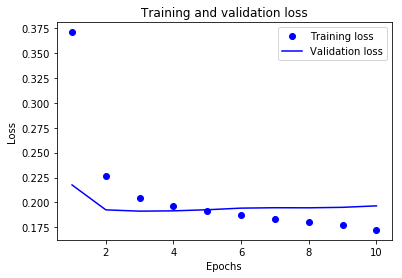

In [9]:
# plotter historikken for 'loss' og 'accuracy'
accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

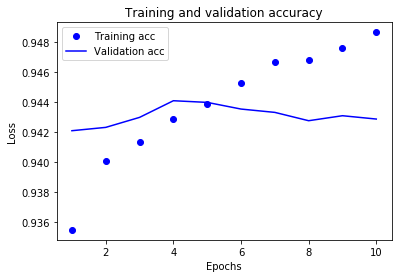

In [10]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [11]:
# vi prøver modellen på test-data

predictions = model.predict(data_test)

for i in range(1,10):
    print(('%1.4f' % predictions[i]))

0.1959
0.0114
0.0007
0.0955
0.0653
0.2704
0.1059
0.0023
0.0803


In [12]:
# finder ud af hvor stor en del store, som er fundet

print('Antal store i datasættet:    ', sum(labels_test))
NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.4 and labels_test[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     621.0
antal estimeret af modellen:  66
Modellens præcision:          11.0 %


In [13]:
# Gennemsnittet for rigtig og forkert

print(' Gennemsnit for test stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels_test[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels_test[i]]))

 Gennemsnit for test stor og lille
0.21000403
0.05024237


In [14]:
# jeg prøver at printe linjenummer, prediction og tekststreng for dem som er store = "rigtige"

print('Jeg printer nogle liner som er sande i test data:')
for i in range(1,300):
    if labels_test[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Jeg printer nogle liner som er sande i test data:
  60  0.0225  Materielmangel: IC4
  66  0.0344  Materiel: manglende ER sæt
  92  0.1449  Materielfejl, holder og fejlsøger i Høje Taastrup. Fejl på bremse?
 128  0.0116  Disponering: 386 kommer ikke med, tiden ændret.
 134  0.1006  Vekselretterfejl i Val. LKI er på.
 148  0.0120  Fejl på tysk radio, vi kan ikke få fejl væk, trods flere forsøg, så der omdisponeres.
 212  0.0031  Materieldisponering: Manglende behov
 238  0.0499  Materielfejl. 1xMQ. Svg. Tekniske problemer. LKI følger op..
 249  0.0648  To MQ i Næ
 254  0.9996  Flyttet fra kl. 17.00  Overgravet kabel i RD.  Prognose til kl. 22:  •	Trafikal vurderin
 256  0.0619  Personalemangel LKF : mgl LKf til følgende ture
 260  0.0120  Fa. Pga. travlhed i DcDK, er klargøring til 749 smuttet.
 268  0.0275  Nedformering fra Sverige samt placering af ET 4320 til eftersyn på HGL
 290  0.0185  Materielmangel KH ABS / ME


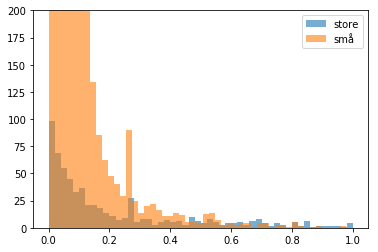

In [15]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_test[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_test[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små')
plt.legend(loc='upper right')
plt.ylim([0, 200])

plt.show()

UHA UHA, alt for mange af de sande har en værdi tæt på 0 ...

### Modellen er ikke specielt præcis. jeg checker lige efter på træninsdata, dem kan man håbe den har lært bedre at kende???

In [16]:
# vi prøver modellen på test-data

predictions = model.predict(data_train)

# print de første predictions
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

0.0428
0.0568
0.0214
0.0154
0.0029
0.0214
0.0043
0.0227
0.0018


In [17]:
# finder ud af hvor stor en del store, som er fundet

print('Antal store i datasættet:    ', sum(labels_train))
NumEstimated = 0
for i in range(1,len(labels_train)):
    if predictions[i]>0.4 and labels_train[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_train)*100), '%')

Antal store i datasættet:     5372.0
antal estimeret af modellen:  1579
Modellens præcision:          29.0 %


In [18]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er RIGTIGE (store)

print('Nogle linjer som er SANDE i train data:')
for i in range(1,300):
    if labels_train[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Nogle linjer som er SANDE i train data:
   6  0.0214  Disponering DSBØ materielmangel 24/11
  10  0.0087  Disponering DSB. Mat. placering.
  13  0.6193  fjernstyrrigsnedbrud Mellem BL-HJ
  36  0.7465  Signalfejl i Os begge veje, fra Øds til Os og retur og fra Os til Rå og retur. Giver 10-20 min. på t
  56  0.1572  Manglende ET
  67  0.0559  Disponering DSB, ET sæt:
  70  0.4603  Materielmangel. Der mangler en del togsæt (både MF og ER) til dagens planlagte produktion..
  97  0.0378  Materielfejl MQ Od, dørfejl
 103  0.4065  Stadig problemer med sporskifte varme og sne fygning i Fh, så vi vender togene ved perron.
 119  0.5821  Mangel på MF generelt i hele landet
 132  0.3890  Bane danmark: Der er et godstog der er gået i stå, det gør vi ikke kan komme over køge til Næ. Vi tø
 133  0.0942  Personalforhold, mangler en Lkf i Helsingør til 2028.
 160  0.0896  Materielfejl MQ : fejl på holdebremse
 174  0.6430  Skinnebrud på Kk, Sporvagt tilkaldt
 176  0.3389  Hed sporskifterne har låst sig

In [19]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er FORKERTE (små)

print('Nogle linjer som er FALSKE i train data:')
for i in range(1,200):
    if labels[i]==0:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Nogle linjer som er FALSKE i train data:
   1  0.0428  K- 19 min.
   2  0.0568  PT mangler vi en enkelt MF´er i Ar... (Pga nedbrud og defekter i løbet af dagen)
   3  0.0214  Ikke kommet op på forespørgsel til IC 4 blev de aflyst kl. 10:30 skulle være kørt kl. 10:05
   4  0.0154  Materielfejl  varm vogn
   5  0.0029  Er forsinket, vi kobler omvendt i Fa.
   7  0.0043  strækningsradio virker ikke  kan ikke resættes
   8  0.0227  Skal til eftersyn på HGL.
   9  0.0018  Disponering Banedanmark. omvendt tilkobling i Fredericia
  11  0.3186  Fejl på Overkørsel  mellem Frs og Hjs
  12  0.0359  KLargøring
  14  0.0015  Materiel.    Placering i AB ICU
  15  0.0440  Disponering af materiel
  16  0.0084  Materiel placering.  MQ.
  17  0.0593  Lkf kan ikke kører MQ. Vi sætter en MR ind i stedet for.
  18  0.0591  Materiel. Vi køre DD I MF løb-
  19  0.0234  Sættet er blevet klar til kørsel til Vk i Ar, har holdt i Vj efter tidligere nedbrud
  20  0.0014  Får nu melding på at indusi er defekt, tog

In [20]:
# finder gennemsnittet for dem som er rigtige og forkerte

print(' Gennemsnit for ttrain stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels[i]]))

 Gennemsnit for ttrain stor og lille
0.28754225
0.04541165


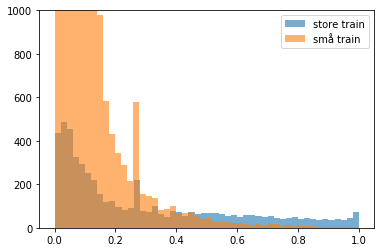

In [21]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_train[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_train[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store train')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små train')
plt.legend(loc='upper right')
plt.ylim([0, 1000])

plt.show()

In [ ]:
# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
labels = labels[indices]